In [1]:
!pip install neurite
!pip install torchio
!pip install ml_collections
!pip install timm
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 108 kB 24.5 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 172 kB 27.3 MB/s 
     |████████████████████████████████| 52.8 MB 266 kB/s 
     |████████████████████████████████| 237 kB 96.1 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 77 kB 6.4 MB/s 
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94524 sha256=73bb66a71f70ee0cb455abc02e2acb85fd744f82e730aeace23e3608164c0f3e
  Stored in directory: /root/.cache/pip/wheels/6d/9f/a9/9e8309035a5bf09ed9086bbca8c9b74cb6413d3eb203e2bc8c
Successfully built ml-collections
Looking in indexes: https://pypi.org/simple, https:/

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from torch.utils.tensorboard import SummaryWriter
import os, glob
import sys
# from torch.utils.data import DataLoader
from tqdm import tqdm
# from data import datasets, trans
import numpy as np
import torch
# from torchvision import transforms
from torch import optim
import torch.nn as nn
import matplotlib.pyplot as plt
from natsort import natsorted
import neurite as ne

os.chdir('/content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/model/CycleICTD')
import utils
import losses
from options.inference_options import get_CycleICTD_config
from data.data_loader import CreateDataLoader
from models.Cycle_ICTD_network import Cycle_ICTD
from train_TransMorph import main
from data import data_util
import models.SpatialTransformer as SpatialTransformer

In [4]:
import random

In [5]:
'''
GPU configuration
'''
GPU_iden = 0
GPU_num = torch.cuda.device_count()
print('Number of GPU: ' + str(GPU_num))
for GPU_idx in range(GPU_num):
    GPU_name = torch.cuda.get_device_name(GPU_idx)
    print('     GPU #' + str(GPU_idx) + ': ' + GPU_name)
torch.cuda.set_device(GPU_iden)
GPU_avai = torch.cuda.is_available()
print('Currently using: ' + torch.cuda.get_device_name(GPU_iden))
print('If the GPU is available? ' + str(GPU_avai))
torch.cuda.empty_cache()

config = get_CycleICTD_config(specie='Human')


Number of GPU: 1
     GPU #0: A100-SXM4-40GB
Currently using: A100-SXM4-40GB
If the GPU is available? True


In [6]:
# main(config)

In [7]:
device = 'cuda'
config.use_checkpoint = True
# config.specie = 'Mouse'
model = Cycle_ICTD(config).load('/content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/model/CycleICTD/experiment/saved_model_CycleIC_Human/Best_model_SSIM.pt', device)
# model = Cycle_ICTD(config).load('/content/drive/MyDrive/Guo_Lab/Registration/model/CycleICTD/experiment/saved_model_CycleIC_Mouse/Best_model_SSIM_v2.pt', device)
model.to(device)

SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[2, 2, 6, 2];drop_path_rate:0.1;reg_head_chan:16


/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


---final upsample expand_first---
SwinTransformerSys expand initial----depths:[2, 2, 6, 2];depths_decoder:[2, 2, 6, 2];drop_path_rate:0.1;reg_head_chan:16
---final upsample expand_first---
Checkpoint /content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/model/CycleICTD/experiment/saved_model_CycleIC_Human/Best_model_SSIM.pt has been loaded!


Cycle_ICTD(
  (transformer): SwinTransformerSys(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(2, 48, kernel_size=(4, 4, 4), stride=(4, 4, 4))
      (norm): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=48, input_resolution=(40, 48, 48), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=48, input_resolution=(40, 48, 48), num_heads=3, window_size=(5, 6, 6), shift_size=(0, 0, 0), mlp_ratio=4.0
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=48, window_size=(5, 6, 6), num_heads=3
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
          

In [8]:
moving_images_path = "/content/drive/MyDrive/Guo_Lab/Registration/Data/unimodal_dataset/human/Aging_Dataset_XYF_BrainAgePaper/subset1"
moving_image_path = os.path.join(moving_images_path, '*')
moving_images = sorted(glob.glob(moving_image_path))

fixed_image = '/content/drive/MyDrive/Guo_Lab/Registration/Data/unimodal_dataset/human/template/MNI_template.nii.gz'

In [9]:
from skimage.metrics import structural_similarity as ssim_loss

import pystrum.pynd.ndutils as nd
def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.
    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims
    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def JD(warp):
    jacobian = jacobian_determinant(warp[0, ...])
    return len(jacobian[jacobian <= 0]) / np.prod(jacobian.shape)


In [10]:
import pystrum.pynd.ndutils as nd

def jacobian_determinant(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.
    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims], 
              where vol_shape is of len nb_dims
    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

def NJ_loss(y_pred, y_true=None): 
    '''
    Penalizing locations where Jacobian has negative determinants
    '''
    # if y_pred.is_cuda:
    #     device = y_pred.get_device()
    # y_pred = y_pred.permute(0, 2, 3, 4, 1).detach().cpu().numpy()
    batch_size = y_pred.shape[0]
    Neg_Jac = 0
    relu = nn.ReLU()
    for b in range(batch_size):
        Neg_Jac += torch.sum(relu(torch.from_numpy(-1 * jacobian_determinant(y_pred[b, ...].squeeze()))))

    return Neg_Jac / batch_size / (y_pred.shape[1] * y_pred.shape[2] * y_pred.shape[3])

In [11]:
import pystrum.pynd.ndutils as nd
import random
from scipy.stats import spearmanr
from scipy.stats import pearsonr
import math


move = '/content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/Data/unimodal_dataset/human/test/bgsp-sub-0007_ses-01_T1w_mri_brainmask_mni152brain_affine_tl.nii.gz'
fix = '/content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/Data/unimodal_dataset/human/test/averaged_200_subject_scan_894.nii.gz'


count = 0
pearson = 0
ssim = 0
psnr = 0
spearman = 0
neg_JD = 0
neg_JD_loss = 0

pearson_inv = 0
ssim_inv = 0
psnr_inv = 0
spearman_inv = 0
neg_JD_inv = 0
neg_JD_loss_inv = 0


# for i in tqdm(range(2000)):
# m = random.randint(0, 1900)

# config.subjectImg = moving_images[i]
# config.templateImg = moving_images[0]

# data_loader_inf = CreateDataLoader(config)
# dataset_inf = data_loader_inf.load_data()


with torch.no_grad():
    # data = next(iter(dataset_inf.__iter__()))
    # moving = data[0][0].permute((0, 4, 1, 2, 3)).cuda()
    # fixed = data[0][1].permute((0, 4, 1, 2, 3)).cuda()
    moving = data_util.load_nib_file(move, config)
    # print(moving.dtype)
    fixed = data_util.load_nib_file(fix, config)
    # print(fixed.dtype)
    moving = torch.from_numpy(moving[np.newaxis, ...])
    fixed = torch.from_numpy(fixed[np.newaxis, ...])
    moving = moving.permute((0, 4, 1, 2, 3)).cuda()
    fixed = fixed.permute((0, 4, 1, 2, 3)).cuda()

    output_mf, output_fm = model(moving, fixed)

    input_moving = moving.permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)
    input_fixed = fixed.permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)

    moved = output_mf[0].permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)
    warp = output_mf[1].permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)
    moved_inv = output_mf[2].permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)
    warp_inv = output_mf[3].permute(0, 2, 3, 4, 1).detach().cpu().numpy().astype(np.float32)
    # print(moved.dtype)
    test_pred = [input_moving, input_fixed, moved, warp]
    
    pearson += pearsonr(moved[0, ...].squeeze().flatten(), input_fixed[0, ...].squeeze().flatten())[0]
    pearson_inv += pearsonr(moved_inv[0, ...].squeeze().flatten(), input_moving[0, ...].squeeze().flatten())[0]

    ssim += ssim_loss(moved.squeeze(), input_fixed.squeeze())
    ssim_inv += ssim_loss(moved_inv.squeeze(), input_moving.squeeze())

    psnr += PSNR(moved, input_fixed) 
    psnr_inv += PSNR(moved_inv, input_moving) 

    neg_JD += JD(warp)
    neg_JD_inv += JD(warp_inv)

    neg_JD_loss += NJ_loss(warp)
    neg_JD_loss_inv += NJ_loss(warp_inv)

    sp = 0
    sp_inv = 0
    for q in range(moved.shape[1]):
        tmp = spearmanr(moved[0, q, ..., 0].squeeze().ravel(), input_fixed[0, q, ..., 0].squeeze().ravel())[0]
        tmp_inv = spearmanr(moved_inv[0, q, ..., 0].squeeze().ravel(), input_moving[0, q, ..., 0].squeeze().ravel())[0]
        if math.isnan(tmp):
            continue
        else:
            sp += tmp
        if math.isnan(tmp_inv):
            continue
        else:
            sp_inv += tmp_inv
    spearman += sp / moved.shape[1]
    spearman_inv += sp_inv / moved.shape[1]

    count += 1


(-0.5, 159.5, 191.5, -0.5)

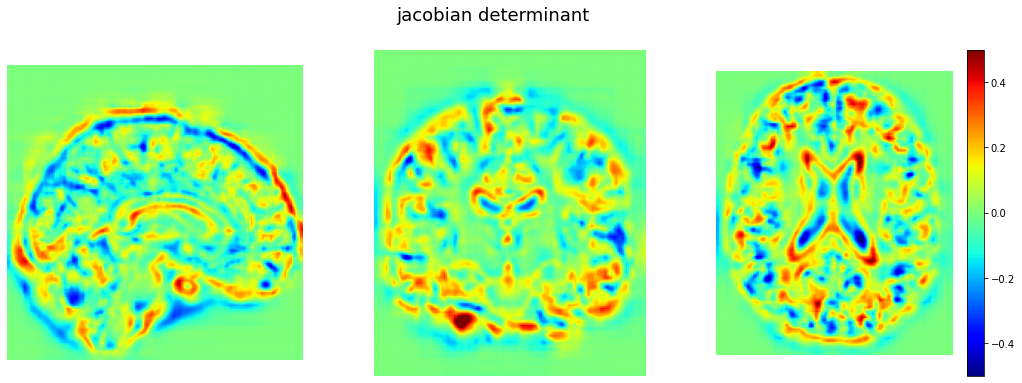

In [12]:
# slices1 = 80
# slices2 = 96
# slices3 = 96
slices1 = 80
slices2 = 96
slices3 = 96

jacobian_det_np_arr = -np.log10(jacobian_determinant(warp[0, ...]))

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(18, 6), ncols=3)
plt.suptitle('jacobian determinant', fontsize=18)

pos1 = ax1.imshow(np.rot90(jacobian_det_np_arr[slices1, :, :], 1), cmap='jet')
# fig.colorbar(pos1, ax=ax1)
pos1.set_clim([-0.5, 0.5])
ax1.axis('off')
# ax1.title('Jacobian Determinant')
pos2 = ax2.imshow(np.rot90(jacobian_det_np_arr[:, slices2, :], 1), cmap='jet')
# fig.colorbar(pos2, ax=ax2)
pos2.set_clim([-0.5, 0.5])
ax2.axis('off')
# plt.title('Jacobian Determinant')
pos3 = ax3.imshow(np.rot90(jacobian_det_np_arr[:, :, slices3], 1), cmap='jet')
fig.colorbar(pos3, ax=ax3)
pos3.set_clim([-0.5, 0.5])
ax3.axis('off')
# plt.title('Jacobian Determinant')


(-0.5, 159.5, 191.5, -0.5)

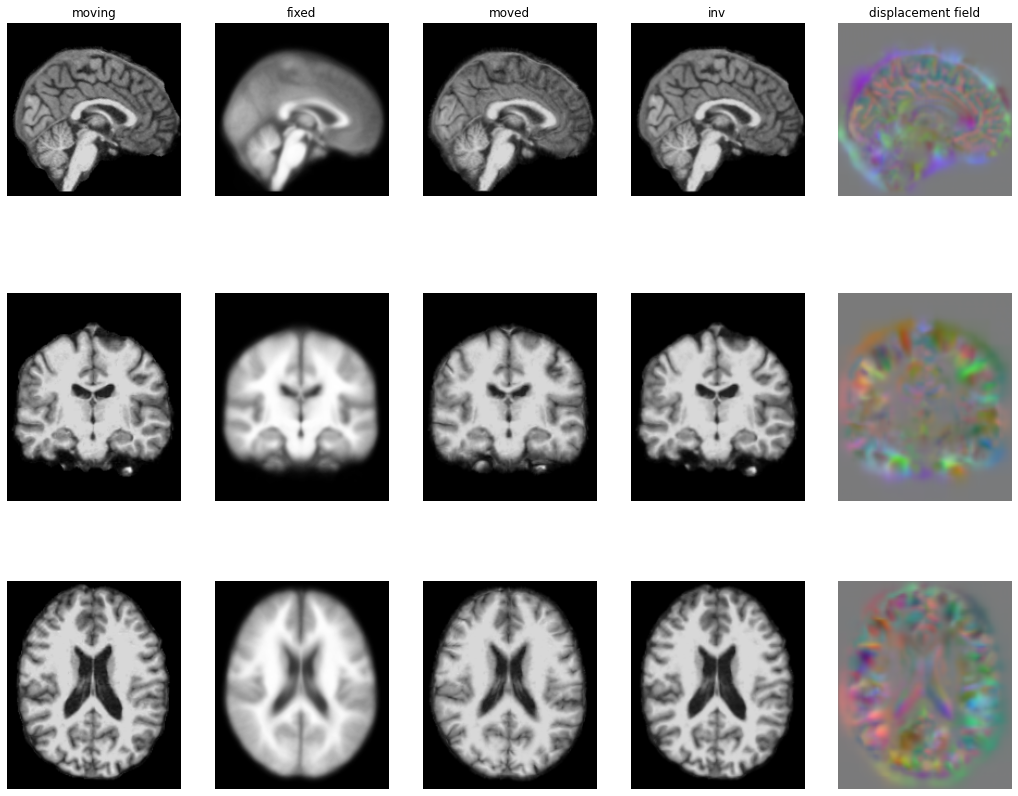

In [13]:
slices1 = 80
slices2 = 96
slices3 = 96

fig = plt.figure(figsize=(18, 15))

plt.subplot(3, 5, 1)
plt.imshow(np.rot90(input_moving[0, slices1, :, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')
plt.title('moving')

plt.subplot(3, 5, 2)
plt.imshow(np.rot90(input_fixed[0, slices1, :, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')
plt.title('fixed')

plt.subplot(3, 5, 3)
plt.imshow(np.rot90(moved[0, slices1, :, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')
plt.title('moved')

plt.subplot(3, 5, 4)
plt.imshow(np.rot90(moved_inv[0, slices1, :, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')
plt.title('inv')

a = (warp - np.min(warp)) / (np.max(warp) - np.min(warp))
plt.subplot(3, 5, 5)
plt.imshow(np.rot90(a[0, slices1, :, :, :], 1))
plt.axis('off')
# plt.colorbar()
plt.clim(0, 1.5)
plt.title('displacement field')

plt.subplot(3, 5, 6)
plt.imshow(np.rot90(input_moving[0, :, slices2, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 7)
plt.imshow(np.rot90(input_fixed[0, :, slices2, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 8)
plt.imshow(np.rot90(moved[0, :, slices2, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 9)
plt.imshow(np.rot90(moved_inv[0, :, slices2, :, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

a = (warp - np.min(warp)) / (np.max(warp) - np.min(warp))
plt.subplot(3, 5, 10)
plt.imshow(np.rot90(a[0, :, slices2, :, :], 1))
plt.axis('off')
###

plt.subplot(3, 5, 11)
plt.imshow(np.rot90(input_moving[0, :, :, slices3, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 12)
plt.imshow(np.rot90(input_fixed[0, :, :, slices3, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 13)
plt.imshow(np.rot90(moved[0, :, :, slices3, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

plt.subplot(3, 5, 14)
plt.imshow(np.rot90(moved_inv[0, :, :, slices3, 0], 1), cmap='gray')
plt.clim(0, 1)
plt.axis('off')

a = (warp - np.min(warp)) / (np.max(warp) - np.min(warp))
plt.subplot(3, 5, 15)
plt.imshow(np.rot90(a[0, :, :, slices3, :], 1))
plt.axis('off')

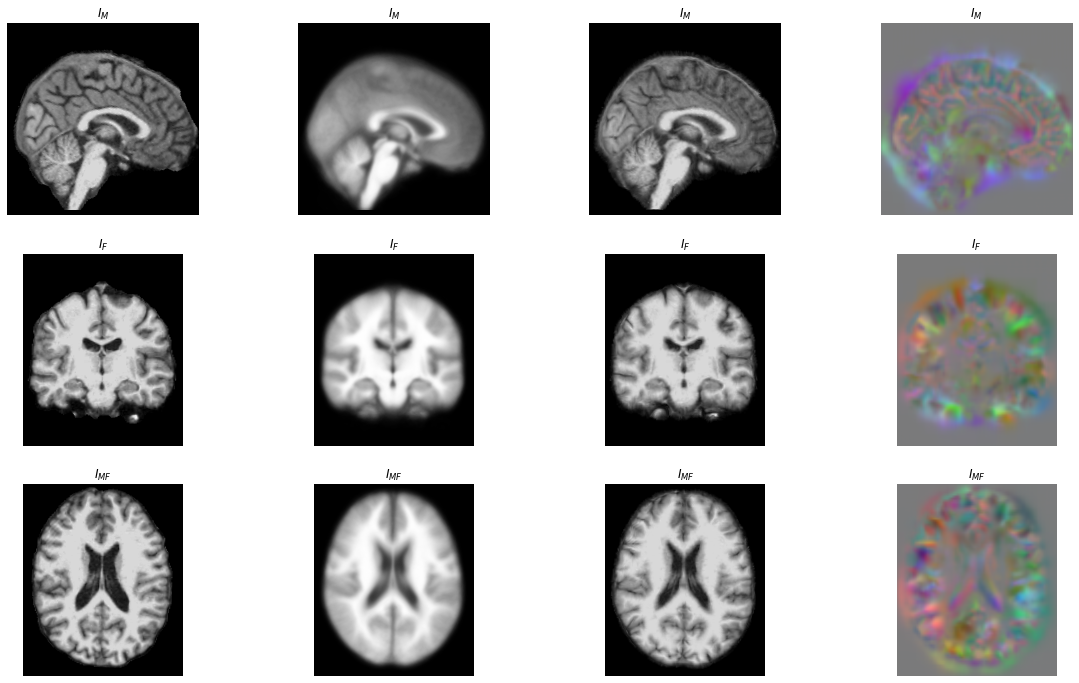

In [14]:
fig = plt.figure(figsize=(20, 12))

rows = 3
cols = 4
count = 1

slices1 = 80
slices2 = 96
slices3 = 96

result = [input_moving, input_fixed, moved, warp]

for img in result:
    
    if count % 4 == 0:
        i = (img - np.min(img)) / (np.max(img) - np.min(img))
        cmap = None
    else:
        i = img[..., 0]
        cmap = 'gray'
        
    plt.subplot(rows, cols, count)
    plt.imshow(np.rot90(i[0, slices1, :, :]), cmap=cmap)
    plt.clim(0, 1)
    plt.axis('off')
    if count <= 4:
        plt.title('$I_M$')
    
    plt.subplot(rows, cols, count + len(result))
    plt.imshow(np.rot90(i[0, :, slices2, :]), cmap=cmap)
    plt.clim(0, 1)
    plt.axis('off')
    if count <= 4:
        plt.title('$I_F$')
    
    plt.subplot(rows, cols, count + len(result) * 2)
    plt.imshow(np.rot90(i[0, :, :, slices3]), cmap=cmap)
    plt.clim(0, 1)
    plt.axis('off')
    if count <= 4:
        plt.title('$I_{MF}$')
    
    count += 1

In [15]:
from google.colab import files
files.download('/content/drive/MyDrive/School/Columbia_University/Guo_Lab/Registration/model/CycleICTD/experiment/saved_model_CycleIC_Human/Best_model_SSIM.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [16]:
!pip freeze

absl-py==1.3.0
aeppl==0.0.33
aesara==2.7.9
aiohttp==3.8.3
aiosignal==1.3.1
alabaster==0.7.12
albumentations==1.2.1
altair==4.2.0
appdirs==1.4.4
arviz==0.12.1
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
async-timeout==4.0.2
atari-py==0.2.9
atomicwrites==1.4.1
attrs==22.1.0
audioread==3.0.0
autograd==1.5
Babel==2.11.0
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==5.0.1
blis==0.7.9
bokeh==2.3.3
branca==0.6.0
bs4==0.0.1
CacheControl==0.12.11
cachetools==5.2.0
catalogue==2.0.8
certifi==2022.9.24
cffi==1.15.1
cftime==1.6.2
chardet==3.0.4
charset-normalizer==2.1.1
click==7.1.2
clikit==0.6.2
cloudpickle==1.5.0
cmake==3.22.6
cmdstanpy==1.0.8
colorama==0.4.6
colorcet==3.0.1
colorlover==0.3.0
commonmark==0.9.1
community==1.0.0b1
confection==0.0.3
cons==0.4.5
contextlib2==0.5.5
convertdate==2.4.0
crashtest==0.3.1
crcmod==1.7
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.0
cvxpy==1.2.2
cycler==0.11.0
cymem==2.0.7
Cython==0.29.32
daft==0.0.4
dask==2022.2.1
datascience==0.17.5
db-dtypes==1.0.4

In [17]:
!pip freeze >> requirements.txt

In [18]:
!python -version

import _frozen_importlib # frozen
import _imp # builtin
import '_thread' # <class '_frozen_importlib.BuiltinImporter'>
import '_warnings' # <class '_frozen_importlib.BuiltinImporter'>
import '_weakref' # <class '_frozen_importlib.BuiltinImporter'>
import '_io' # <class '_frozen_importlib.BuiltinImporter'>
import 'marshal' # <class '_frozen_importlib.BuiltinImporter'>
import 'posix' # <class '_frozen_importlib.BuiltinImporter'>
import '_frozen_importlib_external' # <class '_frozen_importlib.FrozenImporter'>
import _thread # previously loaded ('_thread')
import '_thread' # <class '_frozen_importlib.BuiltinImporter'>
import _weakref # previously loaded ('_weakref')
import '_weakref' # <class '_frozen_importlib.BuiltinImporter'>
# installing zipimport hook
import 'time' # <class '_frozen_importlib.BuiltinImporter'>
import 'zipimport' # <class '_frozen_importlib.FrozenImporter'>
# installed zipimport hook
# /usr/lib/python3.8/encodings/__pycache__/__init__.cpython-38.pyc matches /usr/lib/py

In [19]:
!python --version

Python 3.8.16
